In [1]:
import numpy as np
import matplotlib.pylab as plt
import Functions as F
from astropy.cosmology import Planck15 as Cosmo_AstroPy
from colossus.cosmology import cosmology
import colossus.halo.mass_adv as massdefs
from colossus.lss import mass_function
from colossus.halo.mass_so import M_to_R
from halotools import empirical_models
from scipy.integrate import cumtrapz
import pickle
from scipy.interpolate import interp1d

cosmology.setCosmology("millennium")

Cosmo = cosmology.getCurrent()
HMF_fun = F.Make_HMF_Interp() #N Mpc^-3 h^3 dex^-1
h = Cosmo.h
h_3 = h*h*h



In [25]:
ff = pickle.load(open('FakMa_fun_merg.pkl', 'rb'))

In [38]:
t =10**(np.linspace(6,np.log10(5.e8),100))
dt = t[1:] -t[:-1]

In [70]:
a=np.array([[1,2],[3,4]]).T
b=np.array([1,2])
c = np.zeros((2,3))
c[:,0]

array([0., 0.])

In [68]:
bb = np.append([0],10**(np.linspace(6,9,100)))
#np.searchsorted(bb,[2.e9],side='right')
len(bb)

101

In [37]:
age_now = Cosmo.age(z=2)#, inverse=True)
age_universe = Cosmo.age(z=0)
t_infall = age_now + 10**(np.linspace(-3,np.log10(0.5),100))
lookback = age_universe-t_infall
z_lookback = Cosmo.lookbackTime(lookback, inverse=True)
z_lookback

array([1.99878226, 1.99874179, 1.99869869, 1.99865281, 1.99860395,
       1.99855193, 1.99849655, 1.99843758, 1.99837479, 1.99830793,
       1.99823675, 1.99816097, 1.99808027, 1.99799436, 1.99790289,
       1.9978055 , 1.9977018 , 1.9975914 , 1.99747386, 1.99734872,
       1.99721548, 1.99707363, 1.99692261, 1.99676182, 1.99659064,
       1.9964084 , 1.99621438, 1.99600782, 1.99578793, 1.99555383,
       1.99530462, 1.99503931, 1.99475689, 1.99445624, 1.9941362 ,
       1.99379552, 1.99343287, 1.99304685, 1.99263596, 1.9921986 ,
       1.99173309, 1.99123762, 1.99071027, 1.99014902, 1.98955169,
       1.988916  , 1.9882395 , 1.98751959, 1.98675353, 1.98593837,
       1.98507102, 1.98414817, 1.98316632, 1.98212176, 1.98101053,
       1.97982845, 1.97857109, 1.97723373, 1.97581139, 1.97429878,
       1.97269029, 1.97098   , 1.96916163, 1.96722852, 1.96517365,
       1.96298958, 1.96066846, 1.95820198, 1.95558137, 1.95279739,
       1.94984028, 1.94669976, 1.94336499, 1.93982458, 1.93606

In [33]:
a = np.zeros((4,5))
a[:,3]

array([0., 0., 0., 0.])

In [60]:

def FakMa10_MergerRate_dlog10(M, z,e, dynfrict=False):
    
    
    MergerRate = np.zeros((len(z),len(halos),len(e)))
    A = 0.0104; e_bar = 9.72*(10**-3);alpha = 0.133;beta=-1.995;gamma=0.263;nu=0.0993
    
    for i,zz in enumerate(z):
        for j,m in enumerate(M):
            for k,ee in enumerate(e):
                FakMa10 = A*np.power(10.**(m-12),alpha)*np.power(ee,beta)*np.exp(np.power((ee/e_bar),gamma))*np.power(1+zz, nu)#*ee*np.log(10)
                Weight_cen = HMF_fun(m,zz)/10**m/np.log(10) ## units of h**3
                MergerRate[i][j][k] = FakMa10*Weight_cen
                
    if dynfrict: #Jiang et al. 2008

        for i,zz in enumerate(z):
            for j,m in enumerate(M):
                for k,ee in enumerate(e):
                    frac=(1.+0.22*(ee*np.log(1.+1./ee))**(-1.))**(2./3)
                    zs=zz*frac
                    FakMa10 = A*np.power(10**(m-12),alpha)*np.power(ee,beta)*np.exp(np.power((ee/e_bar),gamma))*np.power(1+zs, nu)#*ee*np.log(10)
                    fmcs = HMF_fun(m,zs)/10**m/np.log(10) ## units of h**3
                    MergerRate[i][j][k] = FakMa10*frac*fmcs

    return MergerRate




In [61]:
halos=  np.array([11,12,13,14,14.5,15]) #p.arange(11,16,0.1)
z = np.array([0.05]) #np.loadtxt('zSTEEL.txt')
ebin=0.05
elog = np.arange(-2.,0,ebin)
e = 10**elog

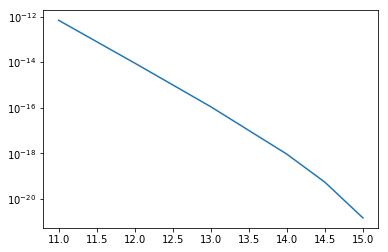

In [48]:
plt.plot(halos, HMF_fun(halos, z)/10**halos)
plt.yscale('log')

In [62]:
MRlog = FakMa10_MergerRate_dlog10(halos,z,e,dynfrict=False)  # units h^3
MRlog_tdyn = FakMa10_MergerRate_dlog10(halos,z,e,dynfrict=True)  # units h^3
#cumul_MRlog = cumtrapz(elog,MRlog[0][0])[::-1] # units h^3


In [63]:
#FakMa_Fun_merg =  (z,halos,elog,MRlog)

In [64]:
#pickle.dump(FakMa_Fun_merg, open('FakMa_fun_merg.pkl', 'wb'))

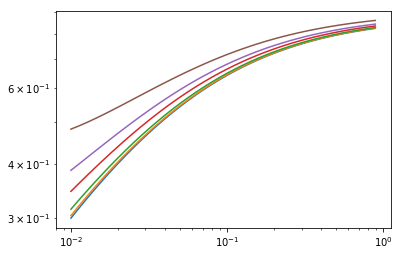

In [66]:
#plt.plot(10**(elog[1:]-ebin/2.),cumul_MR*h_3, lw=10)
#plt.plot(10**(elog[1:]-ebin/2.),cumul_MRlog*h_3, lw=3)

for i in range(len(halos)):
    plt.plot(e,MRlog[0][i]/MRlog_tdyn[0][i])# GIUSTO!!!!
    #plt.plot(e,MRlog_tdyn[0][i]*h_3*1.e9)
plt.yscale('log')
plt.xscale('log')

In [122]:
points = np.array(np.meshgrid(halos,elog,z)).T

newpoints = points.flatten().reshape(points.shape[0]*points.shape[1]*points.shape[2],points.shape[3])
newpoints = list(map(tuple,newpoints))
mr = interpnd.LinearNDInterpolator(newpoints, MRlog.flatten())

In [120]:
points.shape,MRlog.flatten()

((190, 50, 40, 3),
 array([1.13721574e+000, 9.92763194e-001, 8.68618706e-001, ...,
        1.91258194e-226, 1.86344824e-226, 1.82186269e-226]))

# test mass function

In [5]:
import numpy as np
import matplotlib.pylab as plt
import Functions_quicktest as F
from astropy.cosmology import Planck15 as Cosmo_AstroPy
from colossus.cosmology import cosmology
import colossus.halo.mass_adv as massdefs
import pickle
from colossus.lss import mass_function
from scipy.integrate import cumtrapz
from colossus.halo.mass_so import M_to_R
from halotools import empirical_models
cosmology.setCosmology("millennium")
from scipy.interpolate import interp1d,interp2d
from fast_histogram import histogram2d
import pickle

Cosmo = cosmology.getCurrent()
HMF_despali = F.Make_HMF_Interp('despali16') #N Mpc^-3 h^3 dM^-1
HMF_tinker = F.Make_HMF_Interp('tinker08') #N Mpc^-3 h^3 dM^-1

h = Cosmo.h
h_3 = h*h*h

Exception: Delta_m 199 is too small, minimum 200.

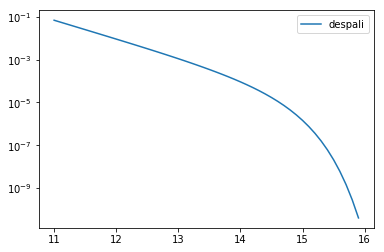

In [3]:
halos = np.arange(11,16,0.1)
z=0.
plt.plot(halos, HMF_despali(halos,z),label='despali')
#plt.plot(halos, HMF_tinker(halos,z),label='tinker')
plt.legend()
plt.yscale('log')

# test mock

In [30]:
import numpy as np
import matplotlib.pylab as plt
import Functions as F
from astropy.cosmology import Planck15 as Cosmo_AstroPy
from colossus.cosmology import cosmology
import colossus.halo.mass_adv as massdefs
import pickle
from colossus.lss import mass_function
from scipy.integrate import cumtrapz
from colossus.halo.mass_so import M_to_R
from halotools import empirical_models
cosmology.setCosmology("millennium")
from scipy.interpolate import interp1d,interp2d
from scipy.integrate import simps
from fast_histogram import histogram2d
import pickle

Cosmo = cosmology.getCurrent()
HMF_fun = F.Make_HMF_Interp() #N Mpc^-3 h^3 dM^-1
h = Cosmo.h
h_3 = h*h*h

burst_law_fun = pickle.load(open('burst_law.pkl','rb'))  #arguments: log10(time[yr]), log10(Mburst_ini), returns: log10SFR(t)

Override =\
{\
'M10':11.95,\
'SHMnorm10':0.032,\
'beta10':1.61,\
'gamma10':0.54,\
'M11':0.4,\
'SHMnorm11':-0.02,\
'beta11':-0.6,\
'gamma11':-0.1\
}

AbnMtch =\
{\
'Behroozi13': False,\
'Behroozi18': False,\
'B18c':False,\
'B18t':False,\
'G18':True,\
'G18_notSE':False,\
'Lorenzo18':False,\
'Moster': False,\
'z_Evo':True,\
'Scatter': 0.11,\
'Override_0': False,\
'Override_z': False,\
'Override': Override,\
'PFT':False,\
'PFT1': False,\
'PFT2': False,\
'PFT3': False\
}

Paramaters = \
{\
'AbnMtch' : AbnMtch,\
'AltDynamicalTime': 1,\
'NormRnd': 0.5,\
 'SFR_Model': 'S15'\
}


plt.rcParams['font.size']=45
plt.rcParams['figure.figsize']=(12,12)
#mpl.rcParams['xtick.minor.visible']=True
plt.rcParams['axes.linewidth']= 3.
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.linewidth']=5
plt.rcParams['xtick.major.size'] =15
plt.rcParams['ytick.major.size'] =15
plt.rcParams['xtick.minor.size'] =10
plt.rcParams['ytick.minor.size'] =10
plt.rcParams['xtick.major.width'] =5
plt.rcParams['ytick.major.width'] =5
plt.rcParams['xtick.minor.width'] =5
plt.rcParams['ytick.minor.width'] =5
plt.rcParams['axes.titlepad'] = 20 

In [3]:
def FakMa10_MergerRate_dlog10(M, zz,e, dynfrict=False):
    
    ''' M in input must be in h units'''
    
    MergerRate = np.zeros((len(M),len(e)))
    z_infall = np.zeros(len(e))
                          
    A = 0.0104; e_bar = 9.72*(10**-3);alpha = 0.133;beta=-1.995;gamma=0.263;nu=0.0993
    masses_FakMa = M - np.log10(h)
                              
    if not dynfrict:           
        
        for j,m in enumerate(M):
            for k,ee in enumerate(e):
                FakMa10 = A*np.power(10**(masses_FakMa[j]-12),alpha)*np.power(ee,beta)*np.exp(np.power((ee/e_bar),gamma))*np.power(1+zz, nu)*ee*np.log(10)
                Weight_cen = HMF_fun(m,zz)/10**m/np.log(10)
                MergerRate[j][k] = FakMa10*Weight_cen
                          
    elif dynfrict: #Jiang et al. 2008
        
        for j,m in enumerate(M):
            for k,ee in enumerate(e):
                #to fit Jiang+08 as in Shen09
                frac=(1.+0.22*(ee*np.log(1.+1./ee))**(-1.))**(2./3)
                z_infall[k]=zz*frac
                FakMa10 = A*np.power(10**(masses_FakMa[j]-12),alpha)*np.power(ee,beta)*np.exp(np.power((ee/e_bar),gamma))*np.power(1+z_infall[k], nu)*ee*np.log(10)

                Weight_cen = HMF_fun(m,z_infall[k])/10**m/np.log(10)
                MergerRate[j][k] = FakMa10*frac*Weight_cen

    return MergerRate,z_infall #merger rate per unit dz, dM dlog10e, volume


In [4]:
def make_burst(Mcen_star,Mcen_gas,Mcen_DM,Msat_star,Msat_gas,Msat_DM,burst_params ):
    #burst law goes here -> get Mburst
    Mcen_star = 10**Mcen_star
    Mcen_gas = 10**Mcen_gas
    Msat_gas = 10**Msat_gas
    Msat_star = 10**Msat_star
    Mbar_cen = Mcen_star + Mcen_gas #+ Mcen_DM
    Mbar_sat = Msat_star + Msat_gas #+ Msa_DM
    merger_ratio_bar = Mbar_sat/Mbar_cen
    
    # add MR >0.1 to avoid eccessive computing time
    mask_mergers = np.ma.masked_greater(merger_ratio_bar,0.1).mask
    
    Mgas_tot = Msat_gas + Mcen_gas
    Mstar_tot = Msat_star + Mcen_star
    fgas_tot = (Mgas_tot)/(Mgas_tot+Mstar_tot)
    fgas_cen = Mcen_gas/(Mcen_gas+Mcen_star)
    if burst_params['burst_law'] =='Hopkins':
        
       # Mburst = Mgas_tot[mask_mergers]*merger_ratio_bar[mask_mergers]*(1-fgas_tot[mask_mergers]) # powers the high mass end of the Mburst function
        Mburst = Mcen_gas[mask_mergers]*merger_ratio_bar[mask_mergers]#*(1-fgas_cen[mask_mergers]) #original Hopkins recipe
    else:
        #new burst law goes here    
        pass
    
    return Mburst,  mask_mergers #,Mgas_tot    #add ~0.2 dex scatter in Mburst?


In [5]:
def burst_history_log(x,t0,M0):
    mtilde = M0/t0
    return t0*np.log(10)*np.e**(-x/mtilde)

In [6]:
def make_final_mstar(mstar,mask):
    int_mask = mask.astype(int)
    zz = np.count_nonzero(int_mask)
    mstar[mask] = mstar[zz]
            
    return mstar
        

In [7]:
params = {'delay':True, 'burst_law': 'Hopkins','tburst_yr': 1.e8,'Ntimes':10000} #delay is whether you account for satellite initialization at the appropriate z. Set 'True' to properly acount for it.
Lbox=250
z=2

In [8]:
def make_mock(z, Lbox):
    
    SFRstep =0.01  
    SFRlog = np.arange(-8,5,SFRstep)
    SFR= 10**SFRlog
    halos_in = np.arange(11,16,0.1)
    max_stars = 12.5; min_stars = 9; bins_stars=0.1
    max_gas = 12; min_gas=6; bins_gas=0.1
    max_sfr = 5 ; min_sfr = -8; bins_sfr =0.1
    max_ssfr = 5 ;min_ssfr = -15; bins_ssfr =0.1
    mstar_bins = np.arange(min_stars,max_stars,bins_stars)
    mgas_bins = np.arange(min_gas,max_gas,bins_gas)
    sfr_bins = np.arange(min_sfr,max_sfr,bins_sfr)
    ssfr_bins = np.arange(min_ssfr,max_ssfr,bins_ssfr)[::-1]
    mstar_len = len(mstar_bins)
    mgas_len =len(mgas_bins)
    sfr_len = len(sfr_bins)
    ssfr_len = len(ssfr_bins)
    
    #times = 10**np.linspace(6,params['tburst_yr'],params['Ntimes'])    
    tb = 3.e9#10**params['tburst_yr']
    array_times_out = np.array([tb*0.01,tb*0.05,tb*0.10,tb*0.15,tb*0.18,tb*0.21,tb*0.25,tb*0.5,tb*0.75,tb])
   # index_times_out = np.append([0], np.searchsorted(times, array_times_out))#timestep where to save output
    SFR_out = np.zeros( ( len(array_times_out)+1, len(mstar_bins), len(sfr_bins)  ) )
    sSFR_out = np.zeros( ( len(array_times_out)+1, len(mstar_bins), len(ssfr_bins)  ) )
    gas_out = np.zeros( ( len(array_times_out)+1, len(mstar_bins), len(mgas_bins)  ) )

    Vol = (Lbox/h)**3
    


    haloMF = HMF_fun(halos_in,z)
    
    step = halos_in[1]-halos_in[0]
    Ncum=Vol*(np.cumsum((haloMF*h_3*step)[::-1])[::-1])
    f = interp1d(Ncum,halos_in)
    array_cumul=np.arange(min(Ncum),max(Ncum))
    halos=f(array_cumul)[::-1]
    
    mstar_cen = F.DarkMatterToStellarMass(halos, z, Paramaters, ScatterOn=True)
    mgas_cen = F.GetGasMass(mstar_cen, z, halos,Paramaters['SFR_Model'])
    SFR_cen = F.StarFormationRate(mstar_cen,z, Paramaters['SFR_Model'])
    
    return mstar_cen,mgas_cen,SFR_cen,halos

In [33]:
tb=1.e9
array_times_out = np.array([tb*0.01,tb*0.05,tb*0.10,tb*0.15,tb*0.18,tb*0.21,tb*0.25,tb*0.5,tb*0.75,tb])
z= [2.4]
cosmo_times_out = Cosmo.lookbackTime(z)-array_times_out/1.e9
cosmo_z_out = Cosmo.lookbackTime(cosmo_times_out, inverse=True)

In [43]:
age_univ_out = Cosmo.lookbackTime(z=2)
zstart = 2.2
array_times_out = Cosmo.lookbackTime(zstart)-age_univ_out
array_times_out

0.30225081798067244

In [161]:
z=0
mst0,mg0,_ ,_= make_mock(z, Lbox)
z=1
mst1, mg1,_,_ = make_mock(z,Lbox)
z=2
mst2,mg2,_ ,_= make_mock(z,Lbox)

# check gas fraction 

(0.1, 16.27683672785107)

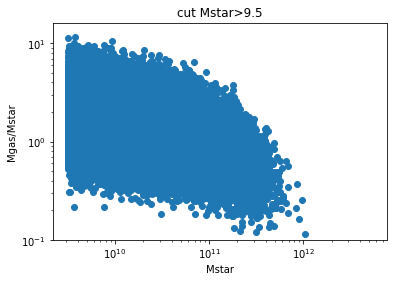

In [138]:

cut_mstar = np.ma.masked_greater(mstar_cen,9.5).mask
plt.scatter(10**mstar_cen[cut_mstar],10**mgas_cen[cut_mstar]/(10**mstar_cen[cut_mstar]))
plt.ylabel('Mgas/Mstar')
plt.xlabel('Mstar')
#plt.text(12,0.7,'z=1')
plt.title('cut Mstar>9.5')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1.e-1)
#plt.savefig('/home/lz1f17/Pictures/SF_mergers/fgas_Mstar.pdf')

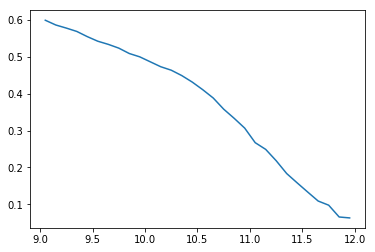

In [93]:
import scipy.stats as scp




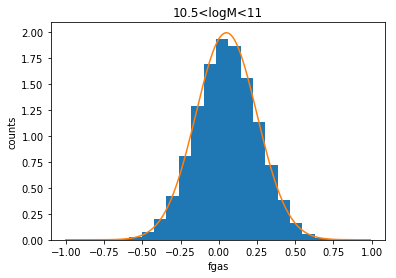

In [111]:
cut_mstar = np.ma.masked_inside(mstar_cen,10.5,11).mask
fgas = np.log10(10**mgas_cen[cut_mstar]/10**mstar_cen[cut_mstar])
plt.hist(fgas, bins = 20,normed=True)
plt.plot(np.arange(-1,1,0.01), scp.norm.pdf(np.arange(-1,1,0.01), loc=0.05, scale=0.2 ))
plt.xlabel('fgas')
plt.ylabel('counts')
plt.title('10.5<logM<11')

In [400]:
a = (10**9.3/(1.e10 +10**9.3))
print('%1e' %(a))

1.663375e-01


In [396]:
10**9.3

1995262314.9688828

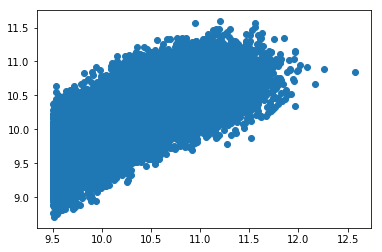

In [10]:
cut_mstar = np.ma.masked_greater(mstar_cen,9.5).mask
plt.scatter(mstar_cen[cut_mstar],mgas_cen[cut_mstar])

In [113]:
frac = Cosmo.lookbackTime(z)

In [115]:
these_z_infall = 
a = F.GetGasMass(mstar_sat,these_z_infall,halosat, Paramaters['SFR_Model'])

array(13.57789454)

In [14]:
def hopkinsGas(mstar,z):
    #f0 = 1./ ( 1. + 10**(mstar-9.15)**0.4  )
    f0 = 1./(1 + (10**mstar/10**9.15)**0.4)
    frac = Cosmo.lookbackTime(z)/Cosmo.lookbackTime(z=500)
    
    try:
        f = f0 *(1. -frac*( 1.- f0**1.5))**(-2./3)
    except:
        f0  = np.tile(f0, (len(z),1))
        f = np.array(list(map( lambda x,y:  x*(1-y*(1.-x**1.5))**(-2./3), *[f0,frac]   )))
        
    

    mgas_sat_hop = np.log10 ( 10**mstar*f/(1.-f))

    return np.random.normal(mgas_sat_hop,0.2)

In [15]:
Gas2 = hopkinsGas(mst2,z=2)
Gas3 = hopkinsGas(mst3,z=3)
Gas4 = hopkinsGas(mst4,z=4)
Gas5 = hopkinsGas(mst5,z=5)



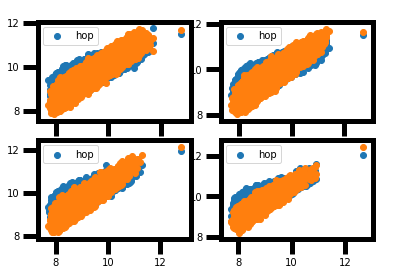

In [16]:
fig , ax = plt.subplots(2,2)
gasses = [Gas2,Gas3,Gas4,Gas5]
stars = [mst2,mst3,mst4,mst5]
zs = [2,3,4,5]
gas_mock = [mg2,mg3,mg4,mg5]
m=0
for i in range(2):
    for j in range(2):
        ax[i][j].scatter(stars[m],gasses[m],label='hop')
        ax[i][j].scatter(stars[m],gas_mock[m])
        ax[i][j].legend()
        m+=1

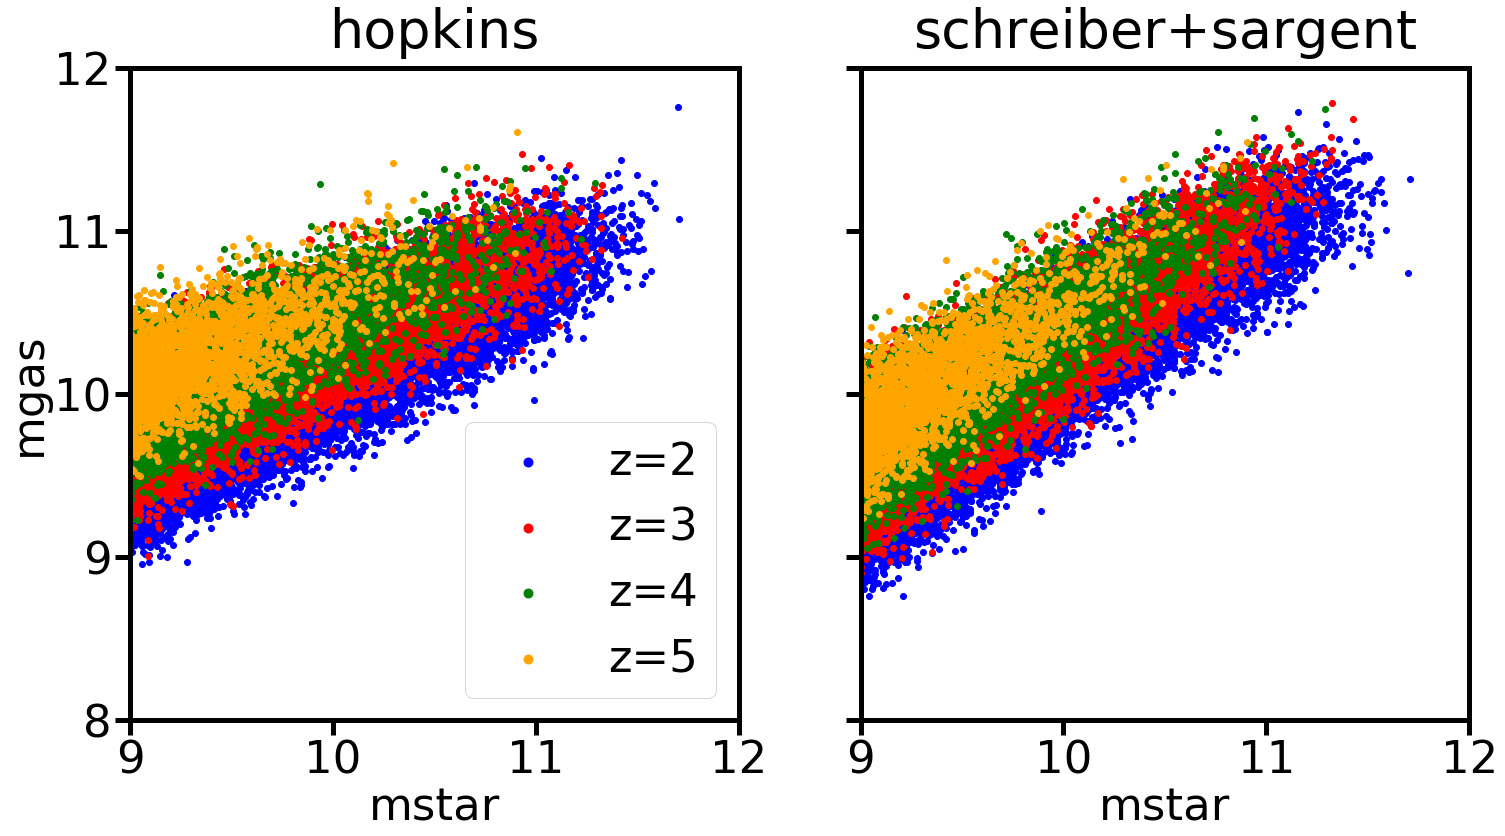

In [32]:
fig,ax = plt.subplots(1,2,sharey=True, figsize=(24,12))
zs = [2,3,4,5]
colors=['blue','red','green','orange']
for m in range(4):
    ax[0].scatter(stars[m],gasses[m],color=colors[m])
    ax[0].scatter(stars[m],50*gasses[m],s=80,label='z='+str(zs[m]),color=colors[m])
    ax[1].scatter(stars[m],gas_mock[m],color=colors[m])
    ax[1].set_ylim(8,12)
    ax[0].set_ylim(8,12)
    ax[1].set_xlim(9,12)
    ax[0].set_xlim(9,12)
ax[0].set_title('hopkins')
ax[1].set_title('schreiber+sargent')
ax[0].set_ylabel('mgas')
ax[0].set_xlabel('mstar')
ax[1].set_xlabel('mstar')
ax[0].legend()
#plt.savefig('/home/lz1f17/Pictures/SF_mergers/mgas_evol.pdf')

In [10]:
def hopkinsGasfrac(mstar,z):
    #f0 = 1./ ( 1. + 10**(mstar-9.15)**0.4  )
    f0 = 1./(1 + (10**mstar/10**9.15)**0.4)
    frac = Cosmo.lookbackTime(z)/Cosmo.lookbackTime(z=500)
    
    try:
        f = f0 *(1. -frac*( 1.- f0**1.5))**(-2./3)
    except:
        f0  = np.tile(f0, (len(z),1))
        print(f0,frac)
        f = np.array(list(map( lambda x,y:  x*(1-y*(1.-x**1.5))**(-2./3), *[f0,frac]   )))
        
    

    
    return f#10**(np.random.normal(np.log10(f),0.2))

In [11]:
def make_medians(mgas, mstar):

    binslow= np.arange(9,12,0.1)
    binsup = binslow +0.1
    bins = binsup-0.05
    fgas = 10**mgas/(10**mstar+10**mgas)

    medians = np.zeros(len(binslow))
    for i in range(len(binslow)):
        m = np.ma.masked_inside(mstar, binslow[i], binsup[i]).mask
        try:
            app = np.percentile(fgas[m],50)
        except:
            app=np.nan
        
        medians[i] = app
    return medians

In [19]:
z=2
mstar_cen,mgas_cen,SFR_cen,halos = make_mock(z,Lbox)

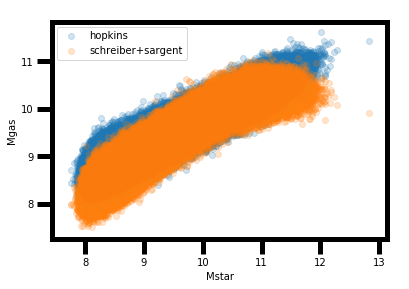

In [21]:
plt.scatter(mstar_cen, hopkinsGas(mstar_cen,0.5),label='hopkins',alpha=0.2)
plt.scatter(mstar_cen,mgas_cen,label='schreiber+sargent',alpha=0.2)
plt.ylabel('Mgas')
plt.xlabel('Mstar')
plt.legend()

[[0.53448394 0.51151089 0.48848911 0.46551606 0.44268837 0.42010024
  0.39784191 0.37599824 0.35464755 0.33386058 0.31369974 0.29421864
  0.27546176 0.25746444 0.24025307 0.22384542 0.20825116 0.19347248
  0.17950479 0.16633753 0.1539549  0.14233668 0.131459   0.12129505
  0.11181577 0.10299047 0.0947874  0.08717419 0.08011834 0.07358756]
 [0.53448394 0.51151089 0.48848911 0.46551606 0.44268837 0.42010024
  0.39784191 0.37599824 0.35464755 0.33386058 0.31369974 0.29421864
  0.27546176 0.25746444 0.24025307 0.22384542 0.20825116 0.19347248
  0.17950479 0.16633753 0.1539549  0.14233668 0.131459   0.12129505
  0.11181577 0.10299047 0.0947874  0.08717419 0.08011834 0.07358756]
 [0.53448394 0.51151089 0.48848911 0.46551606 0.44268837 0.42010024
  0.39784191 0.37599824 0.35464755 0.33386058 0.31369974 0.29421864
  0.27546176 0.25746444 0.24025307 0.22384542 0.20825116 0.19347248
  0.17950479 0.16633753 0.1539549  0.14233668 0.131459   0.12129505
  0.11181577 0.10299047 0.0947874  0.08717419 

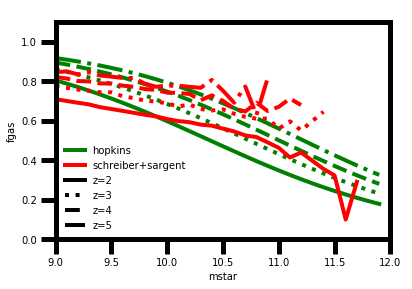

In [12]:
mstar = np.arange(9,12,0.1)
GasMass = np.zeros(len(mstar))
Lbox =150
#z=0
#mst0,mg0,_ ,_= make_mock(z, Lbox)
#z=1
#mst1, mg1,_,_ = make_mock(z,Lbox)
z=2
mst2,mg2,_ ,_= make_mock(z,Lbox)
z=3
mst3,mg3,_ ,_= make_mock(z,Lbox)
z=4
mst4,mg4,_ ,_= make_mock(z,Lbox)
z=5
mst5,mg5,_ ,_= make_mock(z,Lbox)

#mlow = np.ma.masked_less(mstar,10.5).mask
#mhigh = np.ma.masked_greater_equal(mstar,10.5).mask
#GasMass[mlow] = 7.9 + 1.7*F.StarFormationRate(mstar[mlow], z,Paramaters['SFR_Model'], ScatterOn = False )
#GasMass[mhigh] = 9.22 + 0.81*F.StarFormationRate(mstar[mhigh], z,Paramaters['SFR_Model'], ScatterOn = False )
#ss = F.StarFormationRate(np.arange(9,12,0.1), z,Paramaters['SFR_Model'], ScatterOn = False )
#GasMass = 9.22 + 0.81*F.StarFormationRate(mstar, z,Paramaters['SFR_Model'], ScatterOn = False )
#alpha = -0.59*( (z + 1)**0.45 ) #minus here to avoid it later
#GasMass_st09 = mstar + np.log10(0.04) + alpha*(mstar - 11.6532)



#GasMass_hop0 = hopkins(mstar,0)#*10**mstar/(hopkins(mstar,z)*10**mstar + 10**mstar)
#GasMass_hop1 = hopkins(mstar,1)

#GasMass_hop2 = hopkins(mstar,2)

GasMass_hop = hopkinsGasfrac(mstar,[2,3,4,5])
print(GasMass_hop)
GasMass_SS2 = make_medians(mg2,mst2)
GasMass_SS3 = make_medians(mg3,mst3)
GasMass_SS4 = make_medians(mg4,mst4)
GasMass_SS5 = make_medians(mg5,mst5)
#plt.plot(bins, medians, label='sargent KS +schreiber MS')
#plt.plot(mstar,10**GasMass_st09/(10**GasMass_st09+10**mstar), color='red',label='stewart09')
#plt.plot(mstar,hopkins(mstar,0), lw=4,color='green',label='hopkins')
#plt.plot(mstar,hopkins(mstar,1), lw=4,color='green', ls =':')
#plt.plot(mstar,hopkins(mstar,2), lw=4,color='green',ls='--')

plt.plot(mstar,GasMass_hop[0], lw=4,color='green',label='hopkins')
plt.plot(mstar,GasMass_hop[1], lw=4,color='green', ls =':')
plt.plot(mstar,GasMass_hop[2], lw=4,color='green',ls='--')
plt.plot(mstar,GasMass_hop[3], lw=4,color='green',ls='-.')



plt.plot(mstar,GasMass_SS2, lw=4,color='red', label='schreiber+sargent')
plt.plot(mstar,GasMass_SS3, lw=4,color='red', ls=':')
plt.plot(mstar,GasMass_SS4,lw=4, color='red', ls='--')
plt.plot(mstar,GasMass_SS5,lw=4, color='red', ls='-.')

plt.plot(10*mstar,10*mstar, lw=4,color='black', ls='-', label='z=2')
plt.plot(10*mstar,10*mstar, lw=4,color='black', ls=':', label='z=3')
plt.plot(10*mstar,10*mstar, lw=4,color='black', ls='--', label='z=4')
plt.plot(10*mstar,10*mstar, lw=4,color='black', ls='-.', label='z=5')


plt.legend(frameon=False)
plt.ylabel('fgas')
plt.xlabel('mstar')
plt.xlim(9,12)
plt.ylim(0,1.1)
plt.savefig('/home/lz1f17/Pictures/SF_mergers/fgas_hopkins_sargent.png')
#plt.plot(10**ss, 10**(GasMass+0.2), ls=':', color='red')
#plt.plot(10**ss, 10**(GasMass-0.2), ls=':', color='red')
#plt.yscale('log')lw=4,
#plt.xscale('log')

# test Hopkins technique

In [9]:
def make_mergers_mstar(mstar_cen,mgas_cen,halos, z,mstar_low, mstar_up):
    halos_in = np.arange(11,16,0.5) #in h units
    #z_n = np.loadtxt('zSTEEL.txt')
    ebin=0.01
    elog = np.arange(-2.,0,ebin)
    e = 10**elog
    
    #masses for Fak Ma MErger Rate must bu in h units
    MRlog, z_inf = FakMa10_MergerRate_dlog10(halos_in,z,e,dynfrict=True) #merger rate puntuale
    MRlog = MRlog*h_3  
    
    halos_in = halos_in -np.log10(h) #now you can de-h the masses
    mergerRate = interp2d(e,halos_in,MRlog)
    z_infall = interp1d(elog,z_inf)
    
    elog_bins = elog[1]-elog[0]
    cumul_MRlog = np.cumsum(elog_bins*mergerRate(e,halo))#[::-1]
    # elog_int = elog[1:]-ebin
    cumul_interp = interp1d(cumul_MRlog,elog)
    array_cumul = np.random.uniform(min(cumul_MRlog),max(cumul_MRlog),size=len(mstar_cen))
    e_out = cumul_interp(array_cumul)
    halosat = halocen+e_out # product in log space
    
    binning = np.ma.masked_inside(mstar_cen, mstar_low,mstar_up).mask
    Mburst, mask_mergers = make_burst(mstar_cen[binning],mgas_cen[binning],halocen,mstar_sat[binning],mgas_sat[binning],halosat[binning],
params)
    
    return Mburst

In [10]:
Mburst = make_mergers_mstar(mstar_cen,mgas_cen,halos,z,10.8,11.2)

NameError: name 'mstar_cen' is not defined

In [34]:
plt.hist(Mburst)

NameError: name 'Mburst' is not defined

In [393]:
mstar_low =10.8
mstar_up =11.2
z2 = Cosmo.lookbackTime(z=2)#*1.e9
z3 = Cosmo.lookbackTime(z=3)#*1.e9
dt = 0.1
t = np.arange(z2,z3,dt)
t_yr = t*1.e9
dt_yr =dt*1.e9
zs = Cosmo.lookbackTime(t, inverse=True)
#z=np.arange(2,3,0.01)

burst_bins = np.arange(8,12,0.1)
hist_burst = np.zeros((len(t),len(burst_bins)-1))

In [434]:
ss = np.tile(10**sfr_bins, (len(burst_bins),1) )
bb =10**burst_bins
times = 10**np.random.normal(np.log10(params['tburst_yr']),0.1, size=len(burst_bins))
burst_law = np.array(list(map( lambda x,y,z:  burst_history_log(x,z, y), *[ss,bb,times])))

In [44]:
fgas = np.arange(8,12,0.1)
1.-fgas

array([ -7. ,  -7.1,  -7.2,  -7.3,  -7.4,  -7.5,  -7.6,  -7.7,  -7.8,
        -7.9,  -8. ,  -8.1,  -8.2,  -8.3,  -8.4,  -8.5,  -8.6,  -8.7,
        -8.8,  -8.9,  -9. ,  -9.1,  -9.2,  -9.3,  -9.4,  -9.5,  -9.6,
        -9.7,  -9.8,  -9.9, -10. , -10.1, -10.2, -10.3, -10.4, -10.5,
       -10.6, -10.7, -10.8, -10.9])

(10000.0, 1000000000.0)

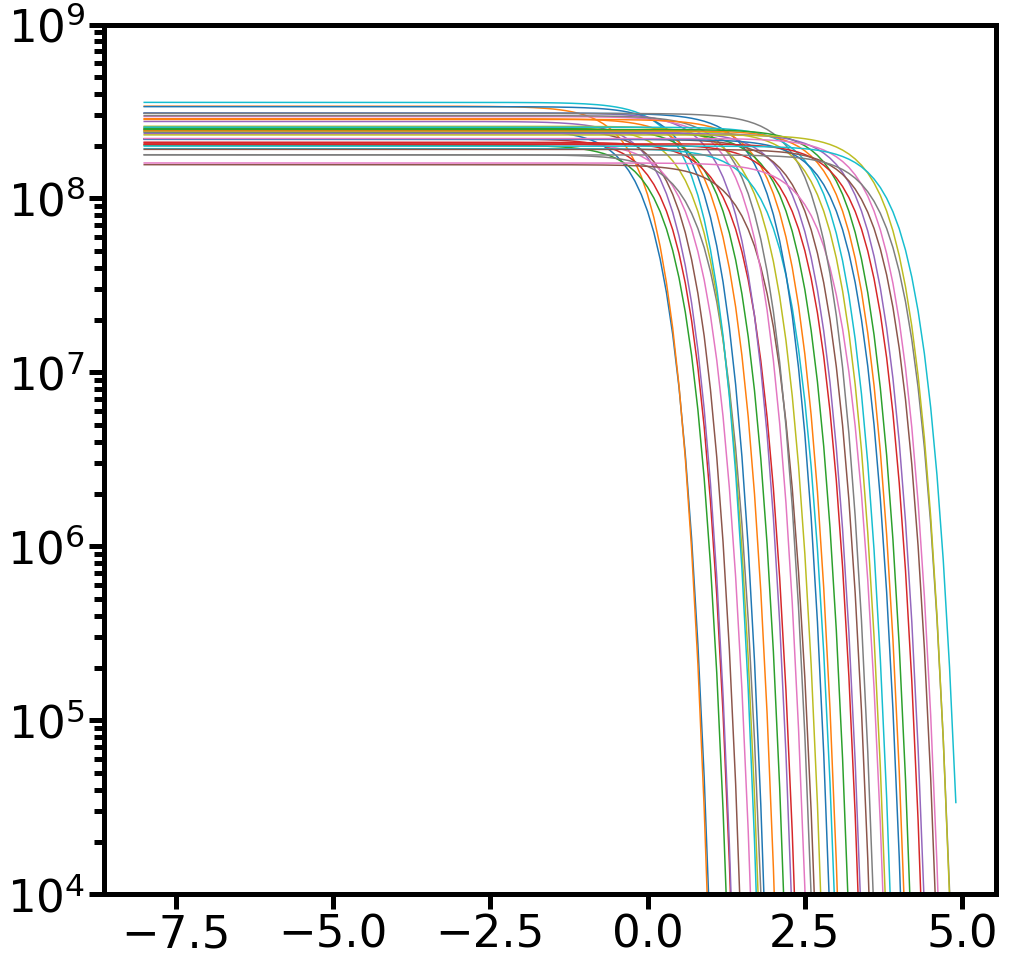

In [436]:
for i in range(len(burst_bins)):
    plt.plot(sfr_bins,burst_law[i])
plt.yscale('log')
plt.ylim(1.e4,1.e9)

In [419]:
bb

array([[1.00000000e+08, 1.25892541e+08, 1.58489319e+08, ...,
        5.01187234e+11, 6.30957344e+11, 7.94328235e+11],
       [1.00000000e+08, 1.25892541e+08, 1.58489319e+08, ...,
        5.01187234e+11, 6.30957344e+11, 7.94328235e+11],
       [1.00000000e+08, 1.25892541e+08, 1.58489319e+08, ...,
        5.01187234e+11, 6.30957344e+11, 7.94328235e+11],
       ...,
       [1.00000000e+08, 1.25892541e+08, 1.58489319e+08, ...,
        5.01187234e+11, 6.30957344e+11, 7.94328235e+11],
       [1.00000000e+08, 1.25892541e+08, 1.58489319e+08, ...,
        5.01187234e+11, 6.30957344e+11, 7.94328235e+11],
       [1.00000000e+08, 1.25892541e+08, 1.58489319e+08, ...,
        5.01187234e+11, 6.30957344e+11, 7.94328235e+11]])

In [396]:
for i in range(len(t)):
    mstar_cen,mgas_cen,SFR_cen,halos = make_mock(zs[i],Lbox)
    bursts = make_mergers_mstar(mstar_cen,mgas_cen,halos,mstar_low, mstar_up)
    
    hist_burst[i] = np.histogram(bursts, bins = burst_bins)[0]

[2.   2.01 2.02 2.03 2.04 2.05 2.06 2.07 2.08 2.09 2.1  2.11 2.12 2.13
 2.14 2.15 2.16 2.17 2.18 2.19 2.2  2.21 2.22 2.23 2.24 2.25 2.26 2.27
 2.28 2.29 2.3  2.31 2.32 2.33 2.34 2.35 2.36 2.37 2.38 2.39 2.4  2.41
 2.42 2.43 2.44 2.45 2.46 2.47 2.48 2.49 2.5  2.51 2.52 2.53 2.54 2.55
 2.56 2.57 2.58 2.59 2.6  2.61 2.62 2.63 2.64 2.65 2.66 2.67 2.68 2.69
 2.7  2.71 2.72 2.73 2.74 2.75 2.76 2.77 2.78 2.79 2.8  2.81 2.82 2.83
 2.84 2.85 2.86 2.87 2.88 2.89 2.9  2.91 2.92 2.93 2.94 2.95 2.96 2.97
 2.98 2.99] 3.2158584691453926


ValueError: setting an array element with a sequence.

In [96]:
def make_burst(Mcen_star,Mcen_gas,Mcen_DM,Msat_star,Msat_gas,Msat_DM,burst_params,merg_thresh ):
    #burst law goes here -> get Mburst
    Mcen_star = 10**Mcen_star
    Mcen_gas = 10**Mcen_gas
    Msat_gas = 10**Msat_gas
    Msat_star = 10**Msat_star
    Mbar_cen = Mcen_star + Mcen_gas #+ Mcen_DM
    Mbar_sat = Msat_star + Msat_gas #+ Msa_DM
    merger_ratio_bar = Mbar_sat/Mbar_cen
    
    # add MR >0.1 to avoid eccessive computing time
    mask_mergers = np.ma.masked_greater(merger_ratio_bar,merg_thresh).mask
    
    Mgas_tot = Msat_gas + Mcen_gas
    Mstar_tot = Msat_star + Mcen_star
    fgas_tot = (Mgas_tot)/(Mgas_tot+Mstar_tot)
    fgas_cen = Mcen_gas/(Mcen_gas+Mcen_star)
    if burst_params['burst_law'] =='Hopkins':
        
        Mburst = Mgas_tot[mask_mergers]*merger_ratio_bar[mask_mergers]*(1-fgas_tot[mask_mergers]) # powers the high mass end of the Mburst function
        #Mburst = Mcen_gas[mask_mergers]*merger_ratio_bar[mask_mergers]*(1.-fgas_cen[mask_mergers]) #original Hopkins recipe
    elif burst_params['burst_law']  == 'no_gas':
        #new burst law goes here    
        #Mburst = Mcen_gas[mask_mergers]*merger_ratio_bar[mask_mergers]#*(1.-fgas_cen[mask_mergers])
        Mburst = Mgas_tot[mask_mergers]*merger_ratio_bar[mask_mergers]#*(1-fgas_tot[mask_mergers]) # powers the high mass end of the Mburst function

    return Mburst,  mask_mergers,fgas_cen #,Mgas_tot    #add ~0.2 dex scatter in Mburst?


# Make mergers

In [63]:
burst_params = {'delay':True, 'burst_law': 'Hopkins','tburst_yr': 1.e8,'Ntimes':10000} #delay is whether you account for satellite initialization at the appropriate z. Set 'True' to properly acount for it.


In [81]:
mstar_cen,mgas_cen,SFR_cen,halos = make_mock(2,Lbox=150)


    #assign merger rate to galaxies in a given halo bin
halowidth = 0.2
halobins = np.arange(11,16,halowidth)
centers = halobins[1:]-halowidth/2.

halocen=13

halos_in = np.arange(11,16,0.5) #in h units
#z_in = np.loadtxt('zSTEEL.txt')
ebin=0.01
elog = np.arange(-2.,0,ebin)
e = 10**elog
    
    #masses for Fak Ma MErger Rate must bu in h units
MRlog, z_inf = FakMa10_MergerRate_dlog10(halos_in,z,e,dynfrict=True) #merger rate puntuale
MRlog = MRlog*h_3  
    
halos_in = halos_in -np.log10(h) #now you can de-h the masses
mergerRate = interp2d(e,halos_in,MRlog)
z_infall = interp1d(elog,z_inf)

elog_bins = elog[1]-elog[0]
cumul_MRlog = np.cumsum(elog_bins*mergerRate(e,halocen))#[::-1]
    # elog_int = elog[1:]-ebin
cumul_interp = interp1d(cumul_MRlog,elog)
array_cumul = np.random.uniform(min(cumul_MRlog),max(cumul_MRlog),size=len(mstar_cen))
e_out = cumul_interp(array_cumul)
halosat = halocen+e_out # product in log space

these_z_infall = z_infall(e_out)
mstar_sat = F.DarkMatterToStellarMass(halosat, these_z_infall, Paramaters, ScatterOn=True)
mgas_sat = F.GetGasMass(mstar_sat,these_z_infall,halosat, Paramaters['SFR_Model'])

In [65]:
'''fgas_sat_hop = hopkinsGas(mstar_sat, these_z_infall)
mgas_sat_hop = np.random.normal(np.log10 ( 10**mstar_sat*fgas_sat_hop/(1-fgas_sat_hop)),0.2)
plt.hist(mgas_sat,bins=20, label='mock' )
plt.hist(mgas_sat_hop, bins=20, label='hop')
plt.legend()'''

"fgas_sat_hop = hopkinsGas(mstar_sat, these_z_infall)\nmgas_sat_hop = np.random.normal(np.log10 ( 10**mstar_sat*fgas_sat_hop/(1-fgas_sat_hop)),0.2)\nplt.hist(mgas_sat,bins=20, label='mock' )\nplt.hist(mgas_sat_hop, bins=20, label='hop')\nplt.legend()"

In [97]:
binning = np.ma.masked_inside(halos, halocen-halowidth/2, halocen+halowidth/2).mask
        #binning = np.ma.masked_inside(mstar_cen, 10.8,11.2).mask
burst_params['burst_law']='Hopkins'
Mburst_fgas, mask_mergers,fgas = make_burst(mstar_cen[binning],mgas_cen[binning],halocen,mstar_sat[binning],mgas_sat[binning],halosat[binning],
burst_params,merg_thresh=0.3)
print(burst_params['burst_law'] )
burst_params['burst_law']  = 'no_gas'
print(burst_params['burst_law'] )

Mburst_nofgas, mask_mergers,fgas = make_burst(mstar_cen[binning],mgas_cen[binning],halocen,mstar_sat[binning],mgas_sat[binning],halosat[binning],
burst_params,merg_thresh=0.3)
len(Mburst_fgas)       # Mburst = 10**(np.random.normal(np.log10(Mburst),0.35))

Hopkins
no_gas


97

(array([ 2.,  2.,  1.,  1.,  4.,  8.,  8.,  7., 10.,  3.,  8.,  3.,  5.,
        11.,  4.,  8.,  2.,  5.,  3.,  2.]),
 array([10.22701299, 10.28541218, 10.34381137, 10.40221056, 10.46060975,
        10.51900894, 10.57740814, 10.63580733, 10.69420652, 10.75260571,
        10.8110049 , 10.86940409, 10.92780329, 10.98620248, 11.04460167,
        11.10300086, 11.16140005, 11.21979925, 11.27819844, 11.33659763,
        11.39499682]),
 <a list of 1 Patch objects>)

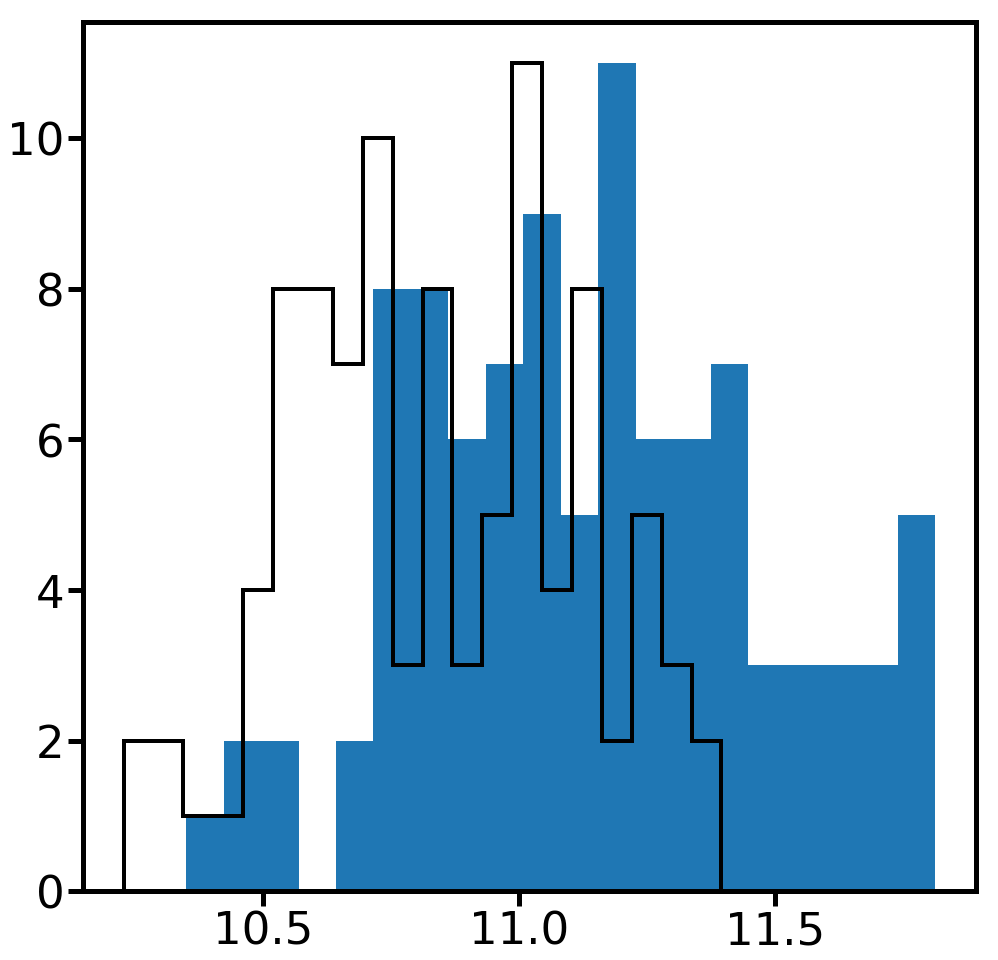

In [98]:
plt.hist(np.log10(Mburst_nofgas),bins=20)
plt.hist(np.log10(Mburst_fgas),bins=20,color='black',histtype='step',lw=4)

# Testing evolution of the burst 

In [18]:
def burst_history_log(x,t0,M0):
    mtilde = M0/t0
    return t0*np.log(10)*np.e**(-x/mtilde)

In [19]:
    SFRstep =0.01   #THIS NEEDS TO GO IN THE BEGINNING OF THE PROGRAM
    SFRlog = np.arange(-10,5,SFRstep)
    SFR= 10**SFRlog
  #  Mburst =  10**np.arange(8,12,0.1)
   # t = np.repeat(1.e8,len(Mburst))
    t = 10**np.random.normal(np.log10(1.e8),0.001,len(Mburst))
    s = np.tile(SFR,(len(Mburst),1))
    a=np.array(list(map(lambda x,y,z: burst_history_log(x,y,z), *[s,t,Mburst])))

In [20]:
#make SFR(t) 
res =np.cumsum(0.01*a,axis=1)
times = np.max(res,axis=1).reshape((len(Mburst),1)) -res

#make Mstar(t)
dt = times[:,:-1]-times[:,1:]#-
dtnew = np.insert(dt, 0, dt[:,0],axis=1)
mass = np.cumsum(s*dtnew,axis=1)
mass = np.max(mass,axis=1).reshape((len(Mburst),1))-mass

#### check SFH (stellar mass buildup during burst)

#### save only at the times given by array_times_out

In [21]:
tt = np.fliplr(times)
ii = np.tile(array_times_out,(len(Mburst),1)) 
indices = np.array(list(map( np.searchsorted, *[tt,ii])))
indices[indices==times.shape[1]] = times.shape[1]-1

In [22]:
ss =np.fliplr(s)
sss = np.array(list(map( lambda x,i: x[i], *[ss,indices])))

mm = np.fliplr(mass)
M =np.array(list(map (lambda x, i : x[i], *[mm,indices])))
M_preburst = mstar_cen[binning][mask_mergers] + mstar_sat[binning][mask_mergers]
#M = np.insert(M_burst,,M_preburst, axis=1)

In [23]:
preburst_stars = 10**mstar_cen[binning][mask_mergers] + 10**mstar_sat[binning][mask_mergers]
SFH = (preburst_stars + M.T).T

In [25]:
a= np.array([[1,2],[3,4]])
b = np.array([0,0])
np.insert(a,0,b ,axis=1)

array([[0, 1, 2],
       [0, 3, 4]])

In [27]:
        burst_bin_width =0.1
        ss = np.tile(10**SFRlog, (len(burst_bins)-1,1) )
        bb =10**(burst_bins[1:]-burst_bin_width/2.)  
        times = 10**np.random.normal(np.log10(params['tburst_yr']),0.1, size=len(burst_bins))
        burst_law = np.array(list(map( lambda x,y,z:  burst_history_log(x,z, y), *[ss,bb,times]))) # e

NameError: name 'burst_bins' is not defined

In [462]:
b = np.array([[1,2],[3,4]])
np.tile(b,(2,1,1))[0]

array([[1, 2],
       [3, 4]])

In [30]:
cosmo_z_out

array([1.99942367, 1.99942367, 1.99942367, 1.99942367, 1.99942367,
       1.99942367, 1.99942367, 1.99942367, 1.99942367, 1.99942367])

### check SFR(t) at the times array_times_out

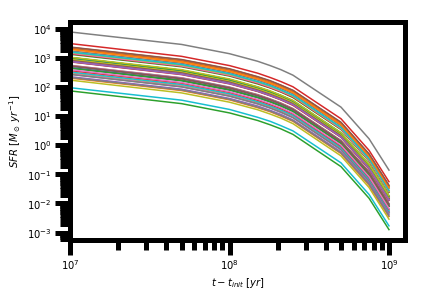

In [26]:
for i in range(len(Mburst)):
    plt.plot(array_times_out,sss[i])
plt.yscale('log')
plt.xscale('log')
plt.xlim(array_times_out[0])
plt.ylabel('$SFR \ [M_\odot \ yr^{-1}]$')
plt.xlabel('$t-t_{init} \ [yr]$')

In [32]:
SFH.T.shape, cosmo_z_out.shape

((10, 40), (10,))

In [45]:
zz=cosmo_z_out[0]
ms = []
for i,zz in enumerate(cosmo_z_out):
    ms.append(F.StarFormationRate(np.log10(SFH.T[i]),zz, Paramaters['SFR_Model'], ScatterOn=False))
ms = np.array(ms).T    

In [51]:
ms2 = \
           np.array(list(map(\
                        lambda x,y: F.StarFormationRate(x,y, Paramaters['SFR_Model'], ScatterOn=False),\
                          *[np.log10(SFH.T),cosmo_z_out])))
ms2=ms2.T

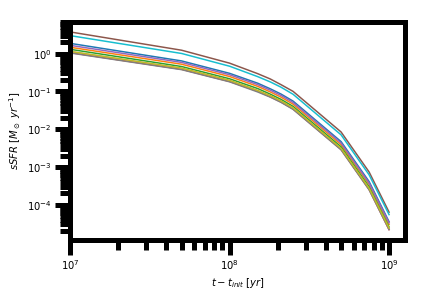

In [48]:
for i in range(10):
       
    plt.plot(array_times_out,sss[i]/10**ms[i])
plt.yscale('log')
plt.xscale('log')
plt.xlim(array_times_out[0])
plt.ylabel('$sSFR \ [M_\odot \ yr^{-1}]$')
plt.xlabel('$t-t_{init} \ [yr]$')

(array([8.0000e+00, 4.6000e+01, 1.6100e+02, 6.5400e+02, 1.6950e+03,
        3.9810e+03, 7.7060e+03, 1.2322e+04, 1.6108e+04, 1.7449e+04,
        1.5617e+04, 1.1535e+04, 7.1720e+03, 3.4640e+03, 1.4120e+03,
        4.7800e+02, 1.4000e+02, 4.4000e+01, 6.0000e+00, 2.0000e+00]),
 array([-10.34038254, -10.19807493, -10.05576732,  -9.91345971,
         -9.7711521 ,  -9.62884449,  -9.48653688,  -9.34422927,
         -9.20192166,  -9.05961404,  -8.91730643,  -8.77499882,
         -8.63269121,  -8.4903836 ,  -8.34807599,  -8.20576838,
         -8.06346077,  -7.92115316,  -7.77884554,  -7.63653793,
         -7.49423032]),
 <a list of 20 Patch objects>)

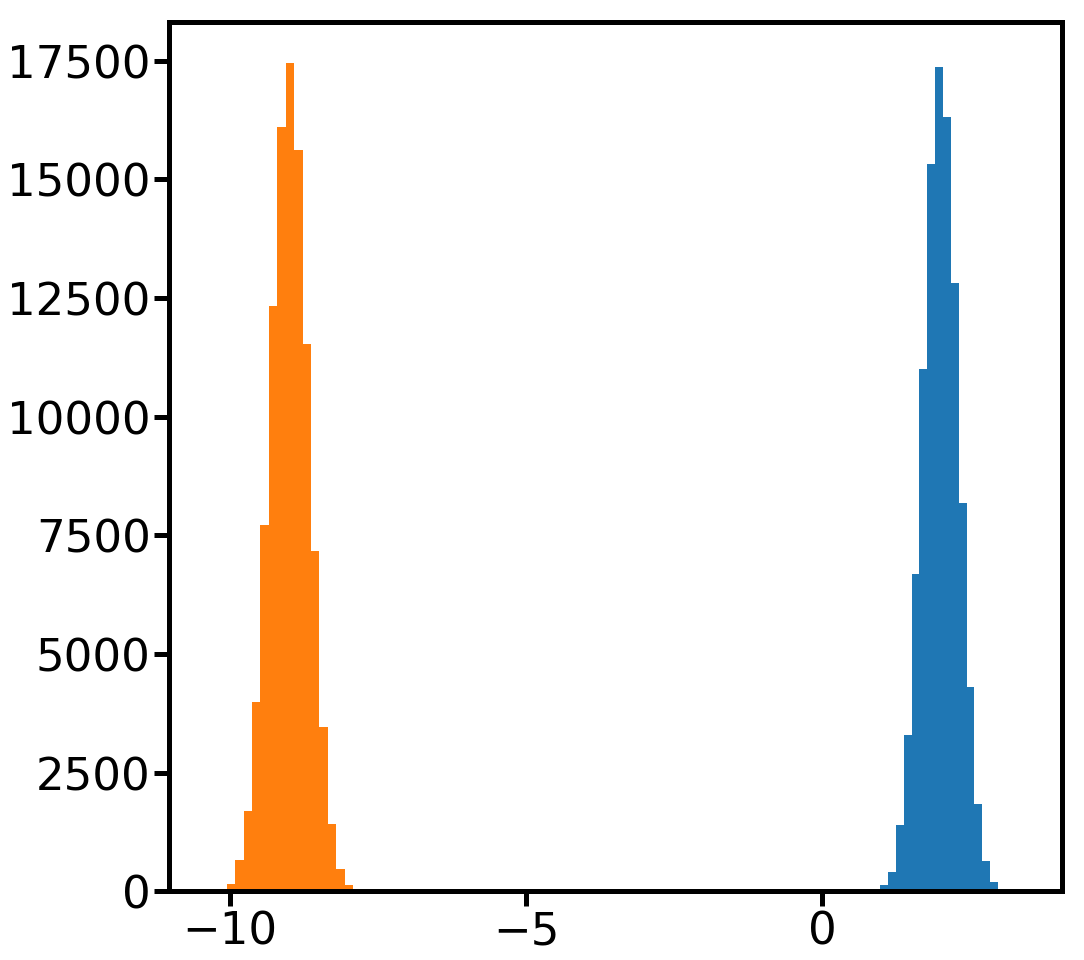

In [6]:
import numpy as np
sfr = 10**np.random.normal(2,0.3,size=100000)
mstar = 10**np.random.uniform(10.8,11.2,size=100000)

plt.hist(np.log10(sfr), bins =20 )

plt.hist(np.log10(sfr/mstar), bins=20)

### function tested above and now working

In [255]:
def burst_evol(Mburst,params,SFR,SFRstep,array_times_out):

    #Hopkins+10 burst law
    t = 10**np.random.normal( np.log10(params['tburst_yr']),0.001,len(Mburst)) #tburst_yr must be in linear units
    s = np.tile(SFR,(len(Mburst),1))
    dtdlogmdot = np.array(list(map(lambda x,y,z: burst_history_log(x,y,z), *[s,t,Mburst])))
    
    
    #SFR evolution
    res =np.cumsum(SFRstep*dtdlogmdot,axis=1)
    times = np.max(res,axis=1).reshape((len(Mburst),1)) -res

    #mass evolution
    dt = times[:,:-1]-times[:,1:]#-
    dtnew = np.insert(dt, 0, dt[:,0],axis=1)
    mass = np.cumsum(s*dtnew,axis=1)
    mass = np.max(mass,axis=1).reshape((len(Mburst),1))-mass

    tt = np.fliplr(times)
    ii = np.tile(array_times_out,(len(Mburst),1)) 
    indices = np.array(list(map( np.searchsorted, *[tt,ii])))
    indices[indices==times.shape[1]] = times.shape[1]-1
    
    ss =np.fliplr(s)
    SFR_out = np.array(list(map( lambda x,i: x[i], *[ss,indices])))
    mm = np.fliplr(mass)
    mstar_out =np.array(list(map (lambda x, i : x[i], *[mm,indices])))
    sSFR_out = SFR_out/mstar_out
    
    cosmo_times_out = Cosmo.lookbackTime(z)-array_times_out/1.e9
    cosmo_z_out = Cosmo.lookbackTime(cosmo_times_out, inverse=True)
    
    cosmo_z_out = np.tile(cosmo_z_out,(len(Mburst),1))
    #need to include gas consumption
    sSFR_MS_mean = \
           np.array(list(map(\
                        lambda x,y: F.StarFormationRate(x,y, Paramaters['SFR_Model'], ScatterOn=False),\
                          *[np.log10(mstar_out),cosmo_z_out])))
    
    sSFR_MS_mean = 10**sSFR_MS_mean/mstar_out
    
    sSFR_MS_burst = sSFR_out/sSFR_MS_mean
    print(sSFR_MS_burst)
    return SFR_out, mstar_out, sSFR_out, sSFR_MS_burst


In [256]:
SFR_burst, stars_formed_burst, sSFR_burst, sSFR_MS_burst = burst_evol(Mburst,params,SFR,SFRstep,array_times_out)

[[1.09567342e+01 1.04017928e+00 1.93177196e-01 ... 1.58059707e-06
  1.06883676e-09 5.09925088e-10]
 [1.08479140e+01 1.03351446e+00 1.92057555e-01 ... 1.55155057e-06
  1.04213548e-09 1.19792848e-09]
 [1.09931065e+01 1.04271398e+00 1.93618416e-01 ... 1.52826302e-06
  1.12552813e-09 1.29378783e-09]
 ...
 [1.11751092e+01 1.05884809e+00 2.02547498e-01 ... 1.86122292e-06
  1.33582272e-09 2.80312674e-10]
 [1.12556771e+01 1.03452297e+00 1.94716584e-01 ... 1.71081333e-06
  1.17390769e-09 3.41154856e-10]
 [1.12726862e+01 1.03433912e+00 1.92343855e-01 ... 1.43624428e-06
  9.06640508e-10 5.08317613e-10]]


In [242]:
sSFR_MS_burst

array([[-5.16305122e-18, -2.44716836e-19, -3.88368657e-20, ...,
        -2.16004616e-25, -1.18703325e-28, -5.06364074e-29],
       [-1.37697215e-17, -6.20613315e-19, -9.86605381e-20, ...,
        -5.36472297e-25, -3.30786029e-28, -3.30786029e-28],
       [-1.43697922e-17, -6.77756969e-19, -1.07469412e-19, ...,
        -6.11521385e-25, -3.85843776e-28, -3.85843776e-28],
       ...,
       [-2.18835304e-18, -9.93082170e-20, -1.58054883e-20, ...,
        -8.79703772e-26, -4.72428740e-29, -8.59678984e-30],
       [-3.06867105e-18, -1.38372551e-19, -2.19991870e-20, ...,
        -1.22410593e-25, -6.72696019e-29, -1.65127292e-29],
       [-5.08364694e-18, -2.42444456e-19, -3.85173565e-20, ...,
        -2.14284599e-25, -1.15077605e-28, -5.02331964e-29]])

# test output 

In [218]:
preburst_stars = 10**mstar_cen[binning][mask_mergers] + 10**mstar_sat[binning][mask_mergers]
SFH = (preburst_stars + stars_formed_burst.T).T
premerg_stars = 10**mstar_cen[binning][mask_mergers]
SFH =  np.insert(SFH,0,premerg_stars, axis=1)

In [219]:
        mgas_preburst = 10**mgas_cen[binning][mask_mergers] + 10**mgas_sat[binning][mask_mergers]
        mgas_new =  (mgas_preburst- stars_formed_burst.T).T
        mgas_premerger= 10**mgas_cen[binning][mask_mergers]
        mgas_new = np.insert(mgas_new,0,mgas_premerger, axis=1)#.T

In [220]:
SFR_preburst = SFR_cen[binning][mask_mergers]
SFR_burst =  np.insert(SFR_burst,0,SFR_preburst, axis=1)

In [221]:
sSFR_preburst = SFR_cen[binning][mask_mergers]/10**mstar_cen[binning][mask_mergers]
sSFR_burst =  np.insert(sSFR_burst,0,sSFR_preburst, axis=1)


In [213]:
        mask_gas = np.ma.masked_less(mgas_new,0).mask #returns True where <0
        SFR_burst[mask_gas] = 1.e-5
        SFH = np.array(list(map( lambda x,y : make_final_mstar(x,y), *[SFH,mask_gas])))

TypeError: 'numpy.bool_' object is not iterable

In [222]:
#SFH = np.log10(SFH)
#SFR_burst = np.log10(SFR_burst)
a=histogram2d(np.log10(SFH[:,s]),np.log10(SFR_burst[:,s]), (mstar_len,sfr_len ), ((min_stars,max_stars),(min_sfr,max_sfr)) )
any(a.flatten()!=0)

True

In [223]:
for i in range(len(a)):
    print(a[i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [225]:
s=0
SFR_out[s] = SFR_out[s] + histogram2d(SFH[:,s],SFR_burst[:,s], (mstar_len,sfr_len ), ((min_stars,max_stars),(min_sfr,max_sfr)) )

In [57]:
            SFR_out[s] = SFR_out[s] + histogram2d(np.log10(SFH[:,s]),np.log10(SFR_burst[:,s]), (mstar_len,sfr_len ), ((min_stars,max_stars),(min_sfr,max_sfr)) )
            sSFR_out[s] = sSFR_out[s] + histogram2d(np.log10(SFH[:,s]),np.log10(sSFR_burst[:,s]), (mstar_len,ssfr_len ), ((min_stars,max_stars),(min_ssfr,max_ssfr)) )
            #mstar_out[s] = mstar_out[s] + histogram1d(mstar_new[:,s]) 
            gas_out[s] = gas_out[s] + histogram2d(np.log10(SFH[:,s]),np.log10(mgas_new[:,s]), (mstar_len,mgas_len ), ((min_stars,max_stars),(min_gas,max_gas)) )

ValueError: operands could not be broadcast together with shapes (35,200) (3,) 

In [67]:
pp=np.histogram2d(np.log10(SFH[:,s]),np.log10(SFR_burst[:,s]), bins=(mstar_bins, sfr_bins) )[0]
any(pp.flatten() !=0)

True

# Test mburst recipes

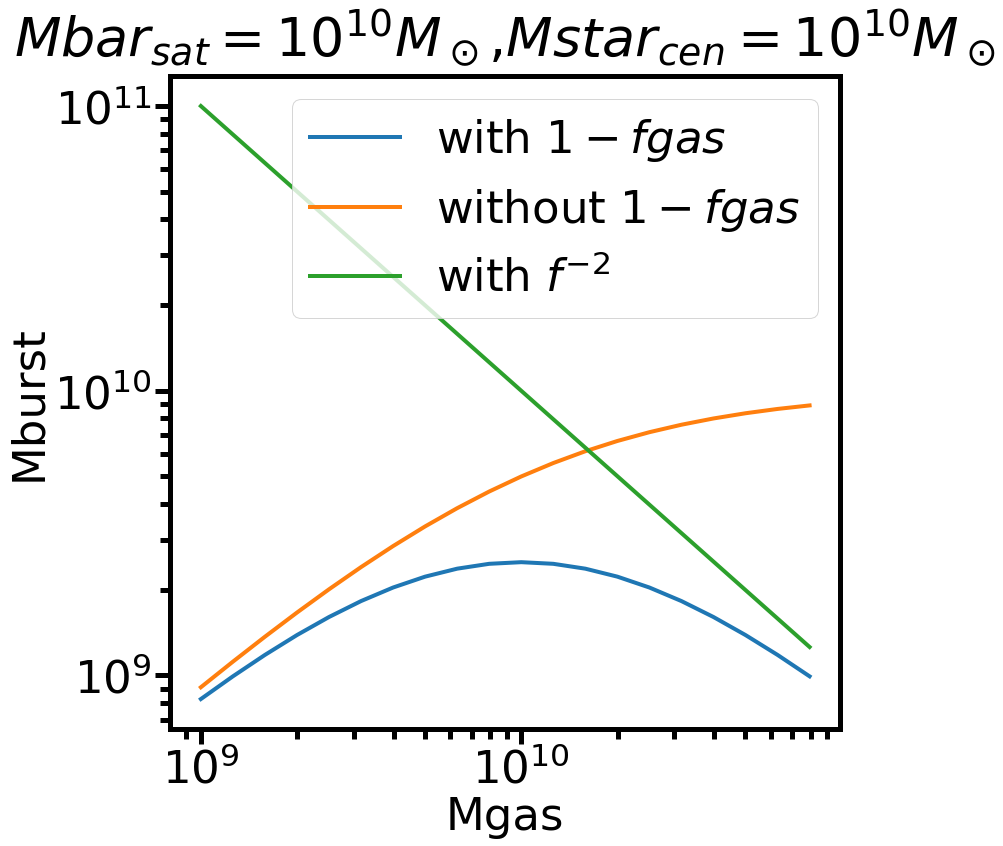

In [8]:
def f(x):
    return x*1.e10/(1.e10+x)**2*1.e10
def g(x):
    return x*1.e10/(1.e10+x)
def l(x):
    return 1.e10*1.e10/x

xx= 10**np.arange(9,11,0.1)
plt.plot(xx,f(xx),label='with $1-fgas$',lw=4)
plt.plot(xx,g(xx), label='without $1-fgas$',lw=4)
plt.plot(xx,l(xx), label='with $f^{-2}$',lw=4)

plt.title('$Mbar_{sat} =10^{10} M_\odot$,$Mstar_{cen}=10^{10} M_\odot$')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mgas')
plt.ylabel('Mburst')

In [25]:
def burst_hop(mgas_cen,mstar_cen,mgas_sat,mstar_sat,alpha=1,beta=1,choice='original'):
    mgas_tot  = mgas_cen+mgas_sat
    mstar_tot = mstar_cen + mstar_sat
    fgas = mgas_tot/(mstar_tot+mgas_tot)
    
    mu = (mstar_sat+mgas_sat)/(mstar_cen+mgas_cen)
    
    if choice == 'original':
        burst = mgas_tot*mu*(1-fgas)
    elif choice =='nofgas':
        burst = mgas_tot*mu
    elif choice == 'alpha':
        burst = mgas_tot*(mu**alpha)*(1-fgas)
    elif choice=='beta':
        burst = mgas_tot*mu*(1-fgas)**beta
    elif choice == 'alphabeta':
        burst = mgas_tot*(mu**alpha)*(1-fgas)**beta
        
    return burst


## z=2 conditions (using

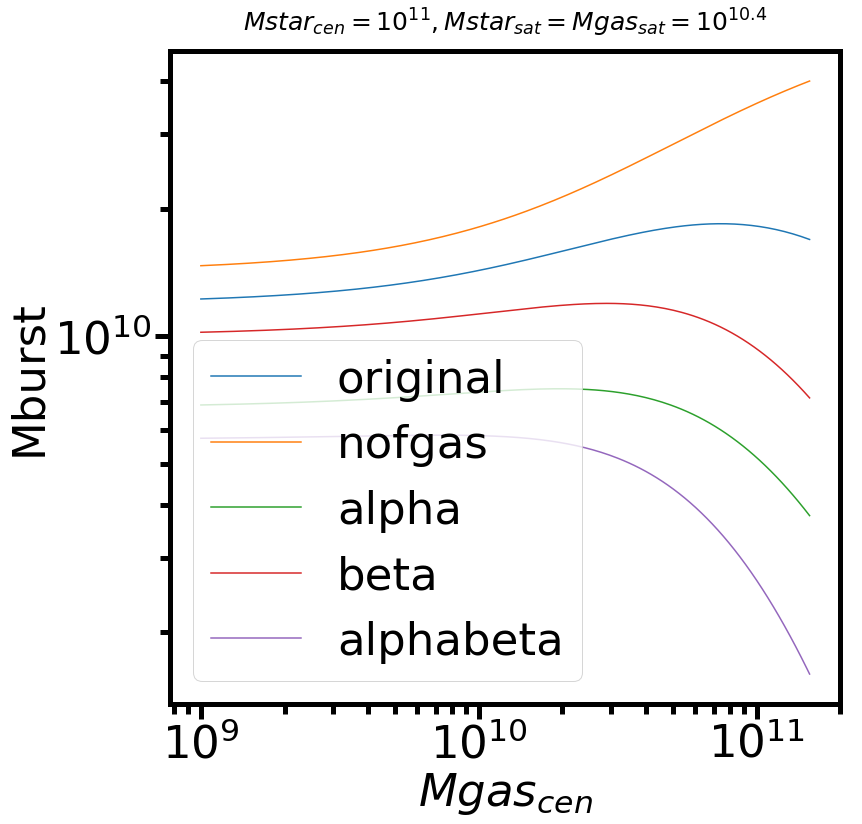

In [29]:
mstar_cen  = 10**11
mgas_cen = 10**np.arange(9,11.2,0.01)
mstar_sat = 10**10.5
mgas_sat = 10**10.4

burstorig = burst_hop(mgas_cen,mstar_cen,mgas_sat,mstar_sat,alpha=1,beta=1,choice='original')
burstnogas = burst_hop(mgas_cen,mstar_cen,mgas_sat,mstar_sat,alpha=1,beta=1,choice='nofgas')
burstalpha = burst_hop(mgas_cen,mstar_cen,mgas_sat,mstar_sat,alpha=2,beta=1,choice='alpha')
burstbeta = burst_hop(mgas_cen,mstar_cen,mgas_sat,mstar_sat,alpha=1,beta=2,choice='beta')
burstalphabeta = burst_hop(mgas_cen,mstar_cen,mgas_sat,mstar_sat,alpha=2,beta=2,choice='alphabeta')
plt.plot(mgas_cen,burstorig, label ='original')
plt.plot(mgas_cen,burstnogas,label='nofgas')
plt.plot(mgas_cen, burstalpha, label='alpha')
plt.plot(mgas_cen, burstbeta, label='beta')
plt.plot(mgas_cen,burstalphabeta, label='alphabeta')

plt.title('$Mstar_{cen}=10^{11}, Mstar_{sat}=Mgas_{sat}=10^{10.4}$', fontsize=25)
plt.xlabel('$Mgas_{cen}$')
plt.ylabel('Mburst')
plt.legend()
plt.xscale('log')
plt.yscale('log')

# z=0 conditions 

In [ ]:
mstar_cen  = 10**11
mgas_cen = 10**np.arange(10.2,11.2,0.01)
mstar_sat = 10**10.5
mgas_sat = 10**10.4

burstorig = burst_hop(mgas_cen,mstar_cen,mgas_sat,mstar_sat,alpha=1,beta=1,choice='original')
burstnogas = burst_hop(mgas_cen,mstar_cen,mgas_sat,mstar_sat,alpha=1,beta=1,choice='nofgas')
burstalpha = burst_hop(mgas_cen,mstar_cen,mgas_sat,mstar_sat,alpha=2,beta=1,choice='alpha')
burstbeta = burst_hop(mgas_cen,mstar_cen,mgas_sat,mstar_sat,alpha=1,beta=2,choice='beta')
burstalphabeta = burst_hop(mgas_cen,mstar_cen,mgas_sat,mstar_sat,alpha=2,beta=2,choice='alphabeta')
plt.plot(mgas_cen,burstorig, label ='original')
plt.plot(mgas_cen,burstnogas,label='nofgas')
plt.plot(mgas_cen, burstalpha, label='alpha')
plt.plot(mgas_cen, burstbeta, label='beta')
plt.plot(mgas_cen,burstalphabeta, label='alphabeta')

plt.title('$Mstar_{cen}=10^{11}, Mstar_{sat}=Mgas_{sat}=10^{10.4}$', fontsize=25)
plt.xlabel('$Mgas_{cen}$')
plt.ylabel('Mburst')
plt.legend()
plt.xscale('log')
plt.yscale('log')